In [16]:
# Stdlib
import sys
import os
import random

# Scientific computing
import numpy as np

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from node2vec import Node2Vec

# Project source
sys.path.append("../../src/")
from synthetic import *
from utils import *
import copy

In [97]:
# ============= FUNCTIONS =================
def N2V(graph, parameters, hyperparameters):
    """Embed `graph` using node2vec.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for node2vec walk generation.
    hyperparameters : dict
        Keyword arguments for word2vec fitting on node2vec-generated walks.
    Returns
    -------
    dict
        Map of node ids to embedded vectors.
    """
    # Sample random walks
    embedding_model = Node2Vec(graph, **{k: v for k, v in parameters.items() if k in ["dimensions","walk_length","num_walks","workers","quiet"]})

    # Embed walks with word2vec and retrieve model
    embedding_model = embedding_model.fit()#**hyperparameters)
    embedding_model = embedding_model.wv

    # Retrieve resultant vectors
    vectors = embedding_model.vectors

    # Retrieve word2vec internal hash of node ids to vector indices
    node_labels = embedding_model.index_to_key

    # Map node ids into corresponding vector
    # This accounts for graphs with non-consecutive node ids
    embedding = {
        int(node_label): vectors[node_index]
        for node_index, node_label in enumerate(node_labels)
    }

    return embedding

def set_parameters_N2V(
    dimensions=128,
    walk_length=30,
    num_walks=100,
    workers=8,
    quiet=True,
    window=10,
    min_count=1,
    batch_words=4,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> Node2Vec embedding <<<
        "dimensions": dimensions,  # euclidean dimension to embedd
        "walk_length": walk_length,  # number of nodes in each walk
        "num_walks": num_walks,  # number of walks per node
        "workers": workers,  # for cpu parallel work
        "quiet": quiet,  # verbose printing
        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> Node2Vec embedding <<<
        "window": window,  # maximum distance between the current and predicted word within a sentence.
        "min_count": min_count,  # ignores all words with total frequency lower than this
        "batch_words": batch_words,  # [unsure]

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters


"""Project source code for applying Laplacian Eigenmap embedding.
"""
# ============= SET-UP =================
# --- Scientific computing ---
from scipy.sparse.linalg import eigsh  # eigensolver
from scipy.linalg import eigh

# --- Network science ---
import networkx as nx


# ============= FUNCTIONS =================
# --- Helpers ---
def _reindex_nodes(graph):
    reindexed_nodes = {
        index: new_index
        for new_index, index in enumerate(sorted(graph.nodes()))
    }  # Allow for non-contiguous node indices
    return reindexed_nodes


# --- Driver ---
def LE(graph, parameters, hyperparameters, dense_error=False):
    """Embed `graph` using Laplacian eigenmaps.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for LE parameter selection.
    hyperparameters : dict
        Keyword arguments for ARPACK convergence parameters.\
    dense_error : bool
        Indicator if graph is dense, i.e., k >= N, by default False.
    Returns
    -------
    ~~np.array~~
    dict
        Map of node ids to embedded vectors (as rows).
    """
    # >>> Book-keeping >>>
    reindexed_nodes = _reindex_nodes(graph)  # fix networkx indexing
    vectors = dict()
    # ! >>> BROKEN >>>
    # ! Non-contiguous indexing in some real remnants is causing
    # ! indexing errors with arrays - generalizing to a dict instead
    # ! All downstream analyses are able to proceed
    # vectors = np.zeros(
    #     (graph.number_of_nodes(), parameters["k"])  # needs k for scipy.sparse.linalg.eigsh
    # )  # initialize embedded vectors
    # ! <<< BROKEN <<<
    # <<< Book-keeping <<<

    # Calculate normalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(graph, nodelist=sorted(graph.nodes()))

    # Compute the eigenspectra of the normalized Laplacian matrix
    # ! >>> BROKEN >>>
    #_, eigenvectors = \
    #    eigsh(L, **parameters, **hyperparameters)
    # ! <<< BROKEN <<<
    # ! >>> HOTFIX >>>
    if dense_error:
        _, eigenvectors = eigh(L.toarray())
    else:
        _, eigenvectors = \
            eigsh(
                L, k=parameters["k"],
                maxiter=hyperparameters["maxiter"],
                tol=hyperparameters["tol"],
                ncv=hyperparameters["NCV"]*graph.number_of_nodes()
            )
    # ! <<< HOTFIX <<<

    # Apply node reindexing (thanks networkx :/)
    for index, new_index in reindexed_nodes.items():
        vectors[index] = eigenvectors[new_index]

    return vectors


def LE_per_component(graph, parameters, hyperparameters, dense_error=False):
    # >>> Book-keeping >>>
    vectors_per_component = []  # list of vector embeddings, canonical ordering
    vectors = {}  # amalgamated mapping of nodes to their embedded vectors (by component)
    # <<< Book-keeping <<<

    # Retrieve each component as a graph
    component_subgraphs = [
        graph.subgraph(component).copy()
        for component in nx.connected_components(graph)
    ]

    # Embed each component by themselves
    for component_subgraph in component_subgraphs:
        vectors_per_component.append(
            LE(component_subgraph, parameters, hyperparameters, dense_error=dense_error)
        )

    # Amalgamate results
    for component_vectors in vectors_per_component:
        for node, vector in component_vectors.items():
            vectors[node] = vector

    return vectors

def set_parameters_LE(
    dimensions=128,
    maxiter=100,
    tol=-8,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> LE embedding <<<
        "k": dimensions,  # needs k for scipy.sparse.linalg.eigsh

        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> LE embedding <<<
        "maxiter": maxiter,
        "tol": tol,
        "NCV": 6,

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters


In [9]:
G=read_file('/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure2/multiplex_network-london.edgelist')

In [10]:
G, H, R_G, R_H, testset = format_system({'graphs':G,'pfi':0.5,'left':1,'right':2,'largest_component':False})

In [28]:
def format_system(params):
    # Process parameters
    pfi = params["pfi"]
    graphs = params["graphs"]
    left = params["left"]
    right = params["right"]

    # Form "raw" duplex
    multiplex = graphs

    # Split into layers
    G, H = duplex_network(multiplex, left, right)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset


def reconstruct_system(testset, G, H, G_, H_, params):
    cls,scores,gt = [],[],[]

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)
        if params["metric"] == "logistic":
            d_G = np.linalg.norm(G_[i] - G_[j])
            d_H = np.linalg.norm(H_[i] - H_[j])
        t_G = d_G / (d_G + d_H)
        t_H = d_H / (d_G + d_H)
        scores.append(t_G)
        if t_G != t_H:
            if t_H > t_G:
                cls_ = 1
            elif t_H < t_G:
                cls_ = 0
            else:
                cls_=np.random.randint(2)
        cls.append(cls_)
    return cls, scores, gt



In [21]:
G, H, R_G, R_H, testset=format_system({'pfi':0.5,'graphs':G,'left':1,'right':2,'largest_component':False})

In [109]:
pm,hm=set_parameters_LE(dimensions=10)
G_=LE(R_G,pm,hm)
H_=LE(R_H,pm,hm)

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [110]:
[a,b,c]=reconstruct_system(testset, G, H, G_, H_, {'metric':'logistic'})

In [111]:
from sklearn.metrics import roc_auc_score,accuracy_score

In [114]:
accuracy_score(c,a)

0.4717948717948718

In [115]:
roc_auc_score(c,a)

0.6801242236024845

In [118]:
i,j=1,77
print(R_G.degree(i),R_G.degree(j),R_H.degree(i),R_H.degree(j))
print(np.linalg.norm(G_[i] - G_[j]),np.linalg.norm(H_[i] - H_[j]))
# print((R_G.degree(i)*R_G.degree(j))/np.linalg.norm(G_[i] - G_[j]))

4 2 3 2
9.604995838089977e-05 3.454175966527893e-15


In [117]:
testset

{(1, 77): 1,
 (1, 219): 1,
 (1, 321): 1,
 (77, 76): 1,
 (106, 105): 1,
 (219, 282): 1,
 (4, 160): 1,
 (6, 345): 1,
 (160, 159): 1,
 (160, 300): 1,
 (7, 8): 1,
 (8, 39): 1,
 (295, 9): 1,
 (295, 110): 1,
 (34, 35): 1,
 (34, 39): 1,
 (34, 119): 1,
 (39, 20): 1,
 (39, 37): 1,
 (10, 348): 1,
 (13, 354): 1,
 (14, 300): 1,
 (15, 16): 1,
 (16, 117): 1,
 (117, 125): 1,
 (181, 38): 1,
 (181, 97): 1,
 (181, 100): 1,
 (181, 245): 1,
 (21, 169): 1,
 (22, 262): 1,
 (23, 24): 1,
 (23, 73): 1,
 (24, 311): 1,
 (73, 361): 1,
 (25, 95): 1,
 (26, 97): 1,
 (26, 191): 1,
 (26, 192): 1,
 (95, 94): 1,
 (191, 293): 1,
 (27, 28): 1,
 (27, 30): 1,
 (27, 31): 1,
 (27, 187): 1,
 (28, 68): 1,
 (29, 49): 1,
 (30, 184): 1,
 (175, 174): 1,
 (187, 86): 1,
 (187, 188): 1,
 (187, 272): 1,
 (67, 214): 1,
 (67, 320): 1,
 (68, 213): 1,
 (49, 47): 1,
 (49, 292): 1,
 (35, 56): 1,
 (35, 343): 1,
 (180, 121): 1,
 (180, 176): 1,
 (180, 214): 1,
 (180, 277): 1,
 (180, 343): 1,
 (56, 57): 1,
 (37, 38): 1,
 (40, 41): 1,
 (41, 52): 

In [82]:
gs=[nx.grid_2d_graph(i,i) for i in range(5,20)]
gs=[nx.convert_node_labels_to_integers(gs[i]) for i in range(15)]
for i in range(15):
    gs[i].add_nodes_from(list(range(int(i*i),400)))

In [101]:
avg_neighbor_distance=[]
for net in gs:
    avg=[]
    pm,hm=set_parameters_LE(dimensions=10)
    e=LE(net,pm,hm)
    for ed in net.edges():
        avg.append(np.linalg.norm(e[ed[0]] - e[ed[1]]))
    avg_neighbor_distance.append(np.mean(avg))

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

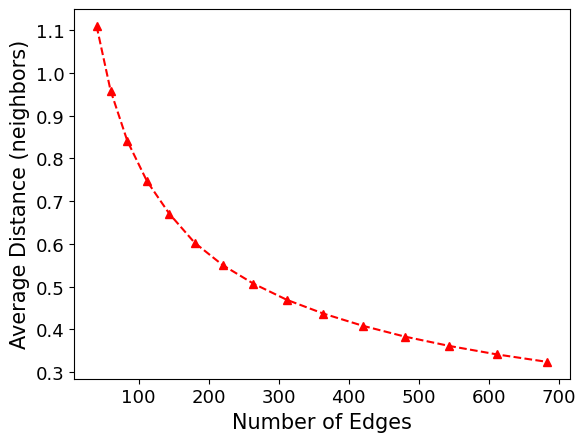

In [102]:
plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [100]:
e

{0: array([-0.00457642, -0.05671353,  0.00785529, -0.02601512, -0.01394941,
        -0.0001121 ,  0.03315915, -0.06620303, -0.04433933, -0.00900726,
        -0.02382295,  0.08541745, -0.07318496, -0.06700702, -0.10358215,
         0.01535639,  0.0092267 , -0.03030262, -0.06103906, -0.01905405,
        -0.00721989, -0.01468957, -0.01899816,  0.07870878,  0.04984919,
         0.0131481 , -0.09182812, -0.02135956,  0.00908634, -0.10219641,
         0.01586089,  0.03291056,  0.0745356 ,  0.05065718, -0.04984308,
         0.00343226, -0.01872706,  0.07448175,  0.04591615, -0.02294776,
         0.05355002, -0.07099437, -0.06891958,  0.03768895,  0.0183637 ,
        -0.07362575,  0.07443087,  0.07414162,  0.02493156,  0.00320121,
        -0.02186127,  0.0426065 ,  0.08312473, -0.0652305 , -0.00507265,
        -0.07037809, -0.07446587, -0.0745356 , -0.04773297, -0.00520747,
         0.01052756,  0.02342727, -0.00670532, -0.0849569 , -0.01206324,
         0.09766396,  0.00474363,  0.07284964,  